In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [3]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [5]:
def draw_landmarks(image, results):
#     mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [6]:
def draw_styled_landmarks(image, results):
    # Draw face connections
#     mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
#                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
#                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
#                              ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [7]:
# check if camera working
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [8]:
cap.release()
cv2.destroyAllWindows()

In [9]:
draw_styled_landmarks(frame, results)

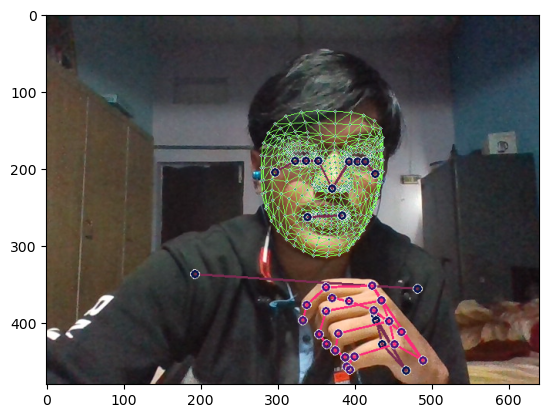

In [10]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [6]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
#     face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

In [12]:
os.mkdir('MP_Data')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'MP_Data'

###### 

## Data Collection


In [14]:

# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['car'])          # CHANGE HERE

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [15]:
DATA_PATH

'MP_Data'

In [18]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [17]:
# dataset generation
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION ({},{})'.format(action,sequence+1), (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [20]:
cap.release()
cv2.destroyAllWindows()

## Testing (ignore from here)



In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [11]:
arr = ['Excuse Me' , 'Thank You'   ,'from'		  ,'jump',	 'sleep'	, 'what',	 'your', 'I',    'airplane',	  'hello'	  ,'my',	 'throw'	, 'where',
'I am Fine',   'clean'	  ,'how are you',   'name'	, 'walk',	 'you']

In [12]:
actions = list(arr)

In [13]:
label_map = {label:num for num, label in enumerate(actions)}

In [14]:
label_map

{'Excuse Me': 0,
 'Thank You': 1,
 'from': 2,
 'jump': 3,
 'sleep': 4,
 'what': 5,
 'your': 6,
 'I': 7,
 'airplane': 8,
 'hello': 9,
 'my': 10,
 'throw': 11,
 'where': 12,
 'I am Fine': 13,
 'clean': 14,
 'how are you': 15,
 'name': 16,
 'walk': 17,
 'you': 18}

In [31]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [32]:
np.array(sequences).shape

(120, 30, 1662)

In [33]:

X = np.array(sequences)

In [34]:

y = to_categorical(labels).astype(int)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05,stratify=y)

In [36]:
y_test.shape

(6, 4)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping
from tensorflow import keras

In [16]:
log_dir = os.path.join('Logs')
tb_callback = [TensorBoard(log_dir=log_dir),EarlyStopping(monitor = 'categorical_accuracy', verbose = 1, restore_best_weights=True,mode="max",patience = 20)]

In [17]:
b_model = keras.Sequential()
b_model.add(keras.layers.Flatten(input_shape=(30,258)))
b_model.add(keras.layers.Dense(units=512, activation='relu', name='dense_1'))
b_model.add(keras.layers.Dropout(0.2))
b_model.add(keras.layers.Dense(19, activation='softmax'))

In [14]:
b_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [63]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback],validation_split=0.15)

Epoch 1/2000
3/3 [==============================] - 5s 485ms/step - loss: 1.3794 - categorical_accuracy: 0.2292 - val_loss: 1.4738 - val_categorical_accuracy: 0.3333
Epoch 2/2000
3/3 [==============================] - 0s 164ms/step - loss: 1.5167 - categorical_accuracy: 0.2708 - val_loss: 1.3695 - val_categorical_accuracy: 0.3333
Epoch 3/2000
3/3 [==============================] - 0s 160ms/step - loss: 1.4010 - categorical_accuracy: 0.3229 - val_loss: 1.3619 - val_categorical_accuracy: 0.3333
Epoch 4/2000
3/3 [==============================] - 0s 164ms/step - loss: 1.3965 - categorical_accuracy: 0.2396 - val_loss: 1.3340 - val_categorical_accuracy: 0.5000
Epoch 5/2000
3/3 [==============================] - 0s 167ms/step - loss: 1.4080 - categorical_accuracy: 0.2604 - val_loss: 1.3520 - val_categorical_accuracy: 0.3889
Epoch 6/2000
3/3 [==============================] - 0s 169ms/step - loss: 1.4045 - categorical_accuracy: 0.2500 - val_loss: 1.3706 - val_categorical_accuracy: 0.3333
Epoc

3/3 [==============================] - 0s 165ms/step - loss: 0.3465 - categorical_accuracy: 0.8646 - val_loss: 0.3461 - val_categorical_accuracy: 0.8333
Epoch 100/2000
3/3 [==============================] - 0s 169ms/step - loss: 0.3094 - categorical_accuracy: 0.8854 - val_loss: 0.3692 - val_categorical_accuracy: 0.8333
Epoch 101/2000
3/3 [==============================] - 0s 179ms/step - loss: 0.3001 - categorical_accuracy: 0.8750 - val_loss: 0.3666 - val_categorical_accuracy: 0.8333
Epoch 102/2000
3/3 [==============================] - 1s 168ms/step - loss: 0.2806 - categorical_accuracy: 0.8958 - val_loss: 0.5650 - val_categorical_accuracy: 0.7778
Epoch 103/2000
3/3 [==============================] - 0s 178ms/step - loss: 0.2758 - categorical_accuracy: 0.8854 - val_loss: 0.3284 - val_categorical_accuracy: 0.7778
Epoch 104/2000
3/3 [==============================] - 0s 164ms/step - loss: 0.2825 - categorical_accuracy: 0.8750 - val_loss: 0.3269 - val_categorical_accuracy: 0.8333
Epoch 1

In [18]:
model.evaluate(X_test,y_test)

NameError: name 'model' is not defined

In [ ]:
model.save('action.h5')

In [ ]:
b_model.load_weights('96%.h5')

In [ ]:
b_model.summary()

In [7]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [67]:
yhat = model.predict(X_test)

1/1 [==============================] - 1s 672ms/step


In [68]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [69]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[4, 0],
        [0, 2]],

       [[4, 0],
        [0, 2]],

       [[4, 1],
        [0, 1]],

       [[5, 0],
        [1, 0]]], dtype=int64)

In [8]:
label_map = {'Excuse Me': 0,
 'Thank You': 1,
 'from': 2,
 'jump': 3,
 'sleep': 4,
 'what': 5,
 'your': 6,
 'I': 7,
 'airplane': 8,
 'hello': 9,
 'my': 10,
 'throw': 11,
 'where': 12,
 'I am Fine': 13,
 'clean': 14,
 'how are you': 15,
 'name': 16,
 'walk': 17,
 'you': 18}

In [9]:
from scipy import stats

In [10]:
colors = [(245,117,16), (117,245,16), (16,117,245), (20,100,150)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [27]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
try:
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():

            # Read feed
            ret, frame = cap.read()

            # Make detections
            image, results = mediapipe_detection(frame, holistic)

            # Draw landmarks
            draw_styled_landmarks(image, results)

            # 2. Prediction logic
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-30:]

            if len(sequence) == 30:
                res = b_model.predict(np.expand_dims(sequence, axis=0))[0]
                print(actions[np.argmax(res)])
                predictions.append(np.argmax(res))


            #3. Viz logic
                if np.unique(predictions[-5:])[0]==np.argmax(res): 
                    if res[np.argmax(res)] >= threshold: 

                        if len(sentence) > 0: 
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])

                if len(sentence) > 7:
                    sentence = sentence[-7:]

                # Viz probabilities
#                 image = prob_viz(res, actions, image, colors)

            cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
            cv2.putText(image, ' '.join(sentence), (3,30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

            # Show to screen
            cv2.imshow('OpenCV Feed', image)

            # Break gracefully
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
except Exception as e:
    print(e)
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 48ms/step
Excuse Me
1/1 [==============================] - 0s 18ms/step
Excuse Me
1/1 [==============================] - 0s 43ms/step
Excuse Me
1/1 [==============================] - 0s 30ms/step
Excuse Me
1/1 [==============================] - 0s 32ms/step
Excuse Me
1/1 [==============================] - 0s 49ms/step
Excuse Me
1/1 [==============================] - 0s 36ms/step
Excuse Me
1/1 [==============================] - 0s 44ms/step
Excuse Me
1/1 [==============================] - 0s 51ms/step
Excuse Me
1/1 [==============================] - 0s 32ms/step
Excuse Me
1/1 [==============================] - 0s 48ms/step
Excuse Me
1/1 [==============================] - 0s 48ms/step
Excuse Me
1/1 [==============================] - 0s 43ms/step
Excuse Me
1/1 [==============================] - 0s 37ms/step
Excuse Me
1/1 [==============================] - 0s 45ms/step
Excuse Me
1/1 [==============================] - 0s 30ms/step
Excuse Me
1/1 [===

1/1 [==============================] - 0s 38ms/step
my
1/1 [==============================] - 0s 40ms/step
my
1/1 [==============================] - 0s 56ms/step
my
1/1 [==============================] - 0s 29ms/step
Excuse Me
1/1 [==============================] - 0s 40ms/step
Excuse Me
1/1 [==============================] - 0s 44ms/step
Excuse Me
1/1 [==============================] - 0s 51ms/step
Excuse Me
1/1 [==============================] - 0s 51ms/step
Excuse Me
1/1 [==============================] - 0s 49ms/step
Excuse Me
1/1 [==============================] - 0s 49ms/step
Excuse Me
1/1 [==============================] - 0s 43ms/step
Excuse Me
1/1 [==============================] - 0s 33ms/step
Excuse Me
1/1 [==============================] - 0s 62ms/step
Excuse Me
1/1 [==============================] - 0s 36ms/step
Excuse Me
1/1 [==============================] - 0s 37ms/step
Excuse Me
1/1 [==============================] - 0s 27ms/step
Excuse Me
1/1 [========================

In [27]:
list(actions)

['Excuse Me',
 'Thank You',
 'from',
 'jump',
 'sleep',
 'what',
 'your',
 'I',
 'airplane',
 'hello',
 'my',
 'throw',
 'where',
 'I am Fine',
 'clean',
 'how are you',
 'name',
 'walk',
 'you']

In [31]:
!pip install tensorflowjs



^C


In [32]:
label_map

{'Excuse Me': 0,
 'Thank You': 1,
 'from': 2,
 'jump': 3,
 'sleep': 4,
 'what': 5,
 'your': 6,
 'I': 7,
 'airplane': 8,
 'hello': 9,
 'my': 10,
 'throw': 11,
 'where': 12,
 'I am Fine': 13,
 'clean': 14,
 'how are you': 15,
 'name': 16,
 'walk': 17,
 'you': 18}